# MobileNet Implementation

In [1]:
%%capture
!pip install pydot
!apt-get install graphviz
!sed -i 's/def _check_pydot()/def _check__pydot()/g' /usr/local/lib/python3.6/dist-packages/keras/utils/vis_utils.py
!sed -i 's/_check_pydot()/#_check_pydot()/g' /usr/local/lib/python3.6/dist-packages/keras/utils/vis_utils.py

In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../tob2/data/train"))

Using TensorFlow backend.
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shiv/.local/lib/python3.7/site-packages/tensorflow/python/framewo

['c2.399.jpg', 'c3.642.jpg', 'c1.718.jpg', 'c1.274.jpg', 'c3.756.jpg', 'c1.564.jpg', 'c2.386.jpg', 'c2.327.jpg', 'c3.798.jpg', 'c4.696.jpg', 'c2.321.jpg', 'c2.707.jpg', 'c4.147.jpg', 'c1.496.jpg', 'c1.799.jpg', 'c2.505.jpg', 'c1.477.jpg', 'c2.674.jpg', 'c3.134.jpg', 'c2.529.jpg', 'c2.423.jpg', 'c2.518.jpg', 'c2.591.jpg', 'c1.60.jpg', 'c1.15.jpg', 'c2.755.jpg', 'c2.205.jpg', 'c4.509.jpg', 'c3.86.jpg', 'c3.486.jpg', 'c3.44.jpg', 'c3.113.jpg', 'c3.130.jpg', 'c3.304.jpg', 'c4.113.jpg', 'c2.173.jpg', 'c3.61.jpg', 'c1.150.jpg', 'c1.586.jpg', 'c4.699.jpg', 'c1.478.jpg', 'c3.112.jpg', 'c4.2.jpg', 'c3.173.jpg', 'c2.133.jpg', 'c1.697.jpg', 'c2.495.jpg', 'c4.709.jpg', 'c4.338.jpg', 'c1.661.jpg', 'c4.254.jpg', 'c1.87.jpg', 'c4.546.jpg', 'c1.224.jpg', 'c1.254.jpg', 'c1.172.jpg', 'c2.138.jpg', 'c4.585.jpg', 'c4.563.jpg', 'c1.549.jpg', 'c4.750.jpg', 'c4.603.jpg', 'c4.224.jpg', 'c2.416.jpg', 'c4.727.jpg', 'c4.201.jpg', 'c1.738.jpg', 'c3.382.jpg', 'c3.295.jpg', 'c2.652.jpg', 'c2.510.jpg', 'c2.340.jpg',

In [3]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

In [13]:
FAST_RUN = False
IMAGE_WIDTH=150
IMAGE_HEIGHT=150
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [14]:
filenames = os.listdir("../tob2/data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'c1':
        categories.append(0)
    elif category == 'c2':
        categories.append(1)
    elif category == 'c3':
        categories.append(2)
    else:
        categories.append(3)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [15]:
df['category'].value_counts()

3    800
1    800
2    800
0    800
Name: category, dtype: int64

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [17]:
earlystop = EarlyStopping(patience=10)

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [19]:
callbacks = [earlystop, learning_rate_reduction]

In [20]:
df["category"] = df["category"].replace({0: 'c1', 1: 'c2', 2:'c3', 3:'c4'}) 

In [21]:
total_train =df.shape[0]

batch_size=15

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df, 
    "../tob2/data/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3200 validated image filenames belonging to 4 classes.


In [23]:
df = df.reset_index(drop=True)
df

,filename,category
0,c2.399.jpg,c2
1,c3.642.jpg,c3
2,c1.718.jpg,c1
3,c1.274.jpg,c1
4,c3.756.jpg,c3
...,...,...
3195,c1.578.jpg,c1
3196,c4.511.jpg,c4
3197,c2.231.jpg,c2
3198,c1.500.jpg,c1


In [24]:
filenames = os.listdir("../tob2/data/validation")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'c1':
        categories.append(0)
    elif category == 'c2':
        categories.append(1)
    elif category == 'c3':
        categories.append(2)
    else:
        categories.append(3)

df1 = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [25]:
df1["category"] = df1["category"].replace({0: 'c1', 1: 'c2', 2:'c3', 3:'c4'}) 

In [26]:
df1 = df1.reset_index(drop=True)
df1

,filename,category
0,c4.147.jpg,c4
1,c3.134.jpg,c3
2,c1.60.jpg,c1
3,c1.15.jpg,c1
4,c3.86.jpg,c3
...,...,...
795,c1.197.jpg,c1
796,c4.169.jpg,c4
797,c3.154.jpg,c3
798,c3.84.jpg,c3


In [27]:
total_validate =df1.shape[0]

In [28]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df1, 
    "../tob2/data/validation", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 4 classes.


In [29]:
def mobilenet(input_shape, n_classes):
  
  def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f, 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
    
    
  input = Input(input_shape)

  x = Conv2D(32, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

In [30]:
input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS);
n_classes = 4;
model = mobilenet(input_shape,n_classes);
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 75, 75, 32)        0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 75, 75, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 75, 75, 32)        0   

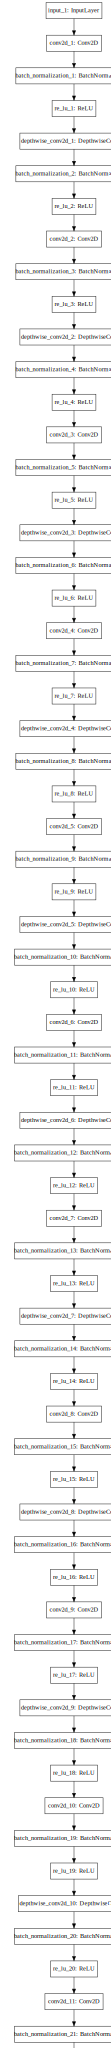

In [31]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [32]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])

In [33]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)


Epoch 1/50
213/213 [==============================] - 543s 3s/step - loss: 1.0974 - acc: 0.5441 - val_loss: 2.0071 - val_acc: 0.2503
Epoch 2/50
213/213 [==============================] - 494s 2s/step - loss: 0.8035 - acc: 0.6662 - val_loss: 1.6993 - val_acc: 0.2510
Epoch 3/50
213/213 [==============================] - 520s 2s/step - loss: 0.7592 - acc: 0.6914 - val_loss: 1.4827 - val_acc: 0.3452
Epoch 4/50
213/213 [==============================] - 509s 2s/step - loss: 0.6587 - acc: 0.7429 - val_loss: 3.7777 - val_acc: 0.5962
Epoch 5/50
213/213 [==============================] - 489s 2s/step - loss: 0.6261 - acc: 0.7601 - val_loss: 0.9463 - val_acc: 0.5019
Epoch 6/50
213/213 [==============================] - 494s 2s/step - loss: 0.5852 - acc: 0.7584 - val_loss: 1.9870 - val_acc: 0.3401

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/50
213/213 [==============================] - 478s 2s/step - loss: 0.5338 - acc: 0.7937 - val_loss: 1.3885 - val

In [37]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.685535  ;  loss = 0.606970 


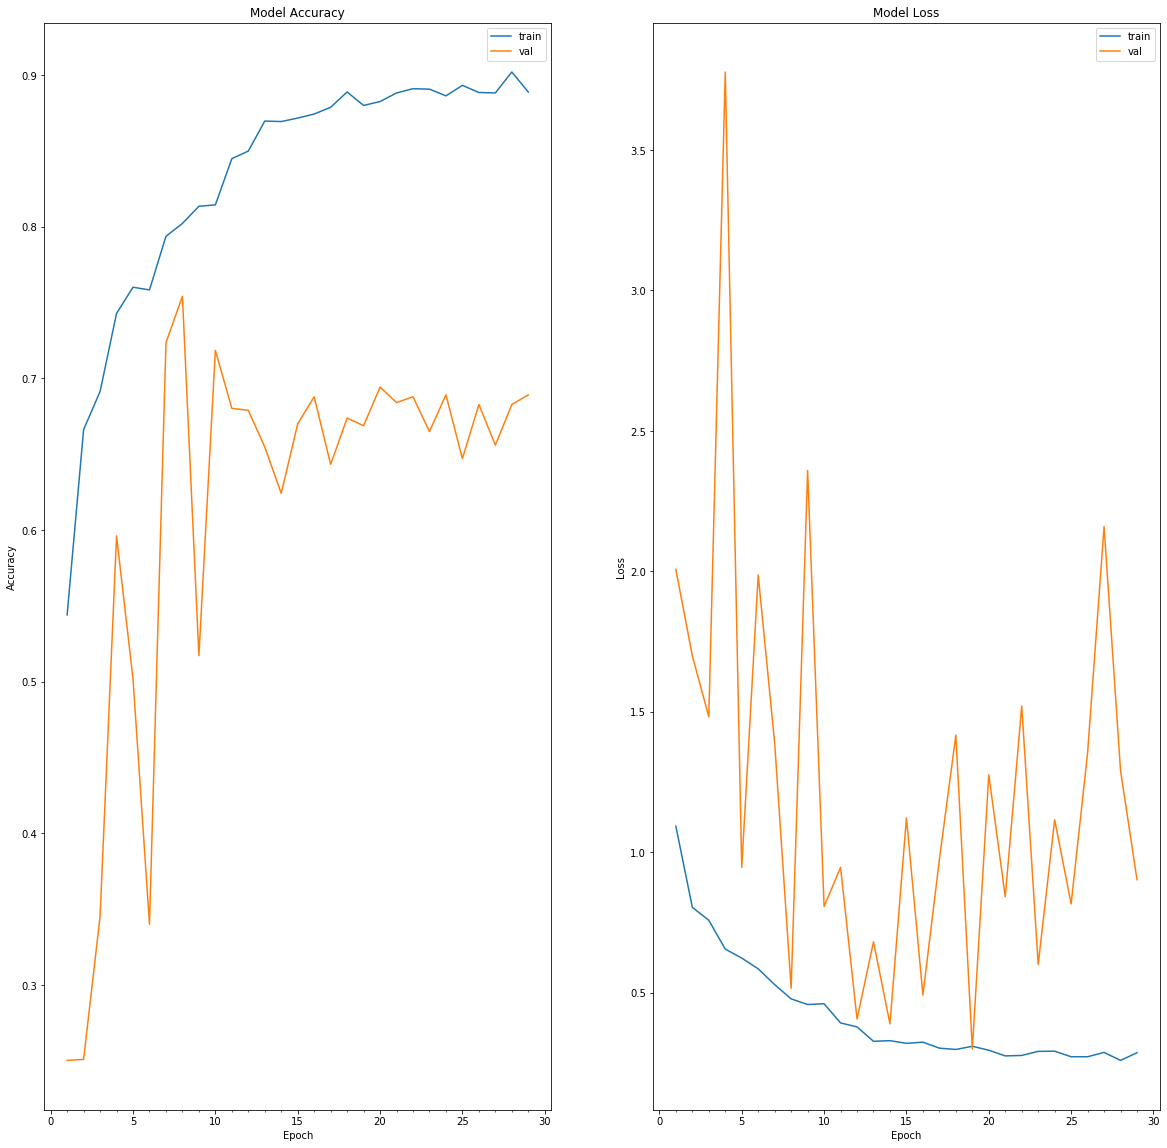

In [41]:
def plot_model_history(model_history, accuracy='acc', val_accuracy='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(20,20))
    axs[0].plot(range(1,len(model_history.history[accuracy])+1),model_history.history[accuracy])
    axs[0].plot(range(1,len(model_history.history[val_accuracy])+1),model_history.history[val_accuracy])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history[accuracy])+1),len(model_history.history[accuracy])/10)
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [43]:
df1['category'] =df1['category'].replace({ 'c1':0,'c2':1,'c3':2,'c4':3})

In [44]:
Y_val=df1['category']

In [45]:
Y_val =Y_val.replace({ 0:'0', 1:'1',2:'2',3:'3'})

In [46]:
from sklearn.preprocessing import MultiLabelBinarizer
one_hot = MultiLabelBinarizer()
Y_val = one_hot.fit_transform(Y_val)

In [47]:
Y_val = [ np.argmax(t) for t in Y_val ]

In [49]:
y_pred =  model.predict_generator(validation_generator)
y_pred

array([[1.84816748e-01, 1.70896035e-02, 7.96677589e-01, 1.41602242e-03],
       [1.13591939e-01, 1.82727814e-01, 6.93726480e-01, 9.95376613e-03],
       [8.90940547e-01, 1.09049007e-01, 8.58899784e-06, 1.85177726e-06],
       ...,
       [2.69673169e-01, 7.26350784e-01, 3.88464192e-03, 9.13737458e-05],
       [8.80808949e-01, 1.18407145e-01, 7.65543606e-04, 1.83974789e-05],
       [2.52862515e-06, 1.35122818e-07, 9.99933004e-01, 6.43181484e-05]],
      dtype=float32)

In [50]:
threshold = 0.5
y_final = np.where(y_pred > threshold, 1,0)
y_final = [ np.argmax(t) for t in y_final ]

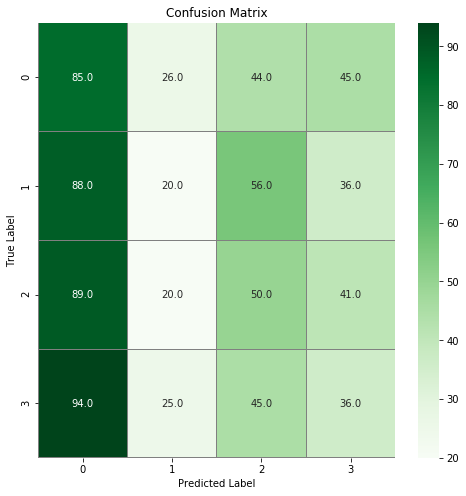

In [51]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final)
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [52]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1','2','3'])

print(report)

              precision    recall  f1-score   support

           0       0.24      0.42      0.31       200
           1       0.22      0.10      0.14       200
           2       0.26      0.25      0.25       200
           3       0.23      0.18      0.20       200

    accuracy                           0.24       800
   macro avg       0.24      0.24      0.22       800
weighted avg       0.24      0.24      0.22       800



In [53]:
test_filenames = os.listdir("/home/shiv/Desktop/tob_train_extra")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [54]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/home/shiv/Desktop/tob_train_extra", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 300 validated image filenames.


In [55]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [56]:
test_df['category'] = np.argmax(predict, axis=-1)

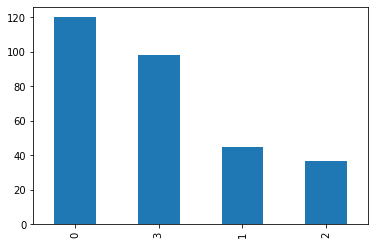

In [57]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
test_df['category'] = test_df['category'].replace({ 'c1': 0, 'c2': 1,'c3': 2,'c4': 3})
test_df['category'].value_counts().plot.bar()

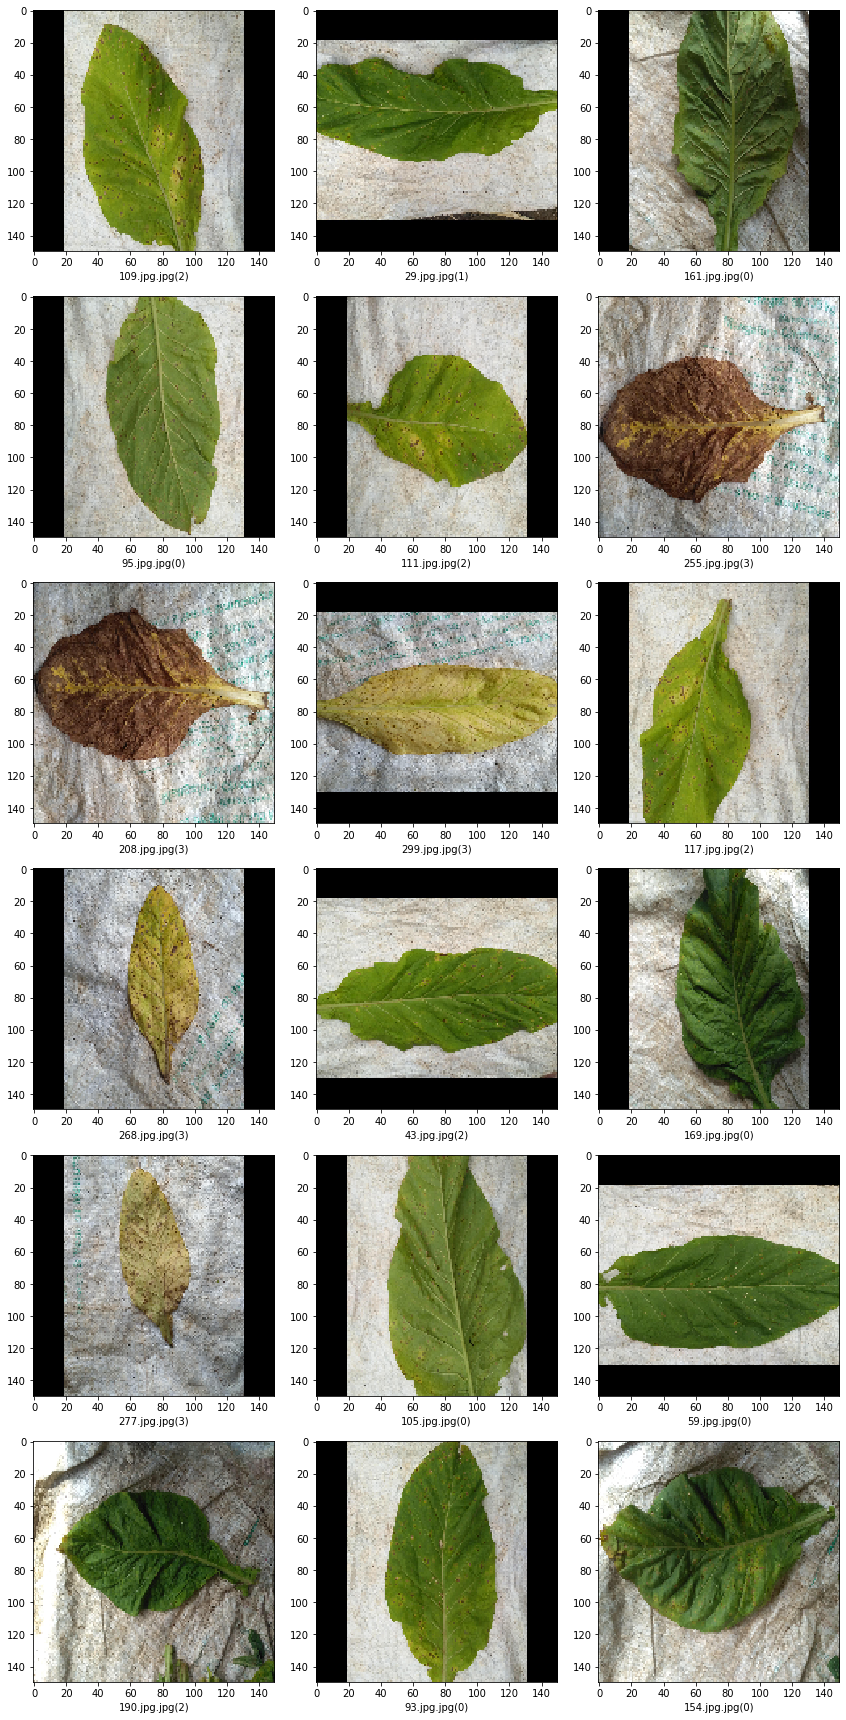

In [58]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/home/shiv/Desktop/tob_train_extra/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()